In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Fake Documents Predictions\Font\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 482 files [00:00, 932.35 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
4 folder and 0 images in output\test
0 folder and 4 images in output\test\Agency
0 folder and 8 images in output\test\Akzidenz Grotesk
0 folder and 8 images in output\test\Algerian
0 folder and 6 images in output\test\Arial
4 folder and 0 images in output\train
0 folder and 53 images in output\train\Agency
0 folder and 111 images in output\train\Akzidenz Grotesk
0 folder and 107 images in output\train\Algerian
0 folder and 90 images in output\train\Arial
4 folder and 0 images in output\val
0 folder and 14 images in output\val\Agency
0 folder and 29 images in output\val\Akzidenz Grotesk
0 folder and 28 images in output\val\Algerian
0 folder and 24 images in output\val\Arial


In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (32, 78, 3)


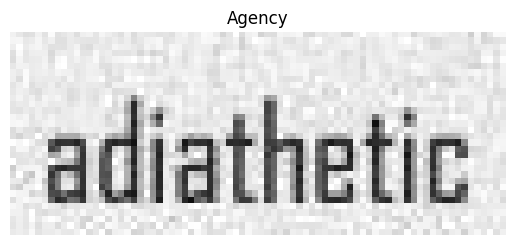

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Agency')

Image Shape : (32, 159, 3)


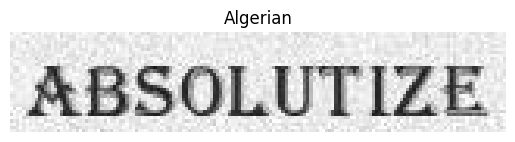

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Algerian')

In [9]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [10]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 361 images belonging to 4 classes.
Found 95 images belonging to 4 classes.
Found 26 images belonging to 4 classes.


In [11]:
train_data.class_indices

{'Agency': 0, 'Akzidenz Grotesk': 1, 'Algerian': 2, 'Arial': 3}

In [12]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [13]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (361,)
val_y.shape:  (95,)
test_y.shape:  (26,)


In [14]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [15]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(4)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

Epoch 1/50


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.2747 - loss: 1.6147 - val_accuracy: 0.4632 - val_loss: 1.3203
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4615 - loss: 1.2583 - val_accuracy: 0.5368 - val_loss: 1.1856
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5657 - loss: 1.0448 - val_accuracy: 0.6316 - val_loss: 0.9720
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5689 - loss: 0.9818 - val_accuracy: 0.6947 - val_loss: 0.8839
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6360 - loss: 0.9137 - val_accuracy: 0.7053 - val_loss: 0.7885
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6519 - loss: 0.8589 - val_accuracy: 0.7474 - val_loss: 0.7303
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7349 - loss: 0.7795 - val_accuracy: 0.8211 - val_loss: 0.6745
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.7497 - loss: 0.6928 - val_accuracy: 0.8632 - val_loss: 0.6312
Epoch 9/50
6/6 ━━━━

In [19]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

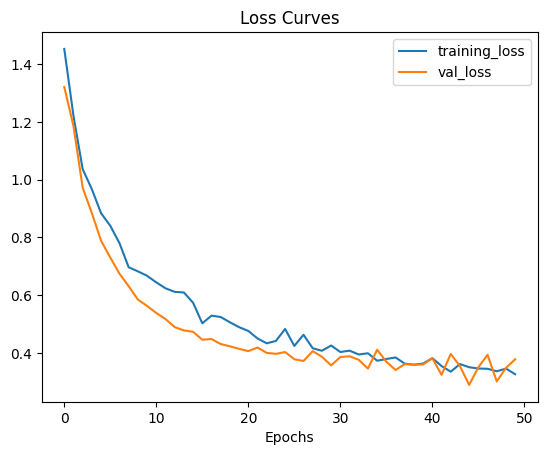

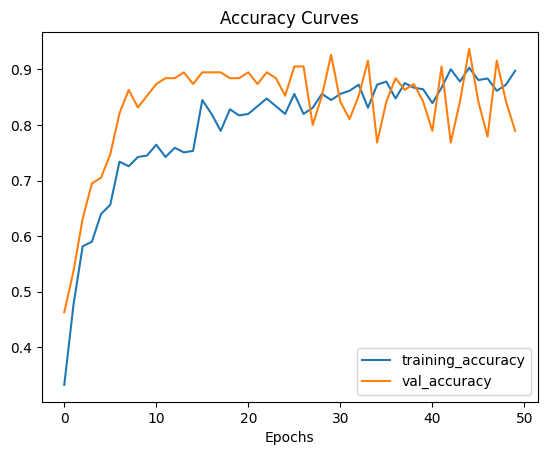

In [20]:
plot_loss_curves(history)

In [21]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.31      1.00      0.47         9
           2       1.00      1.00      1.00        28
           3       1.00      0.56      0.72        43

    accuracy                           0.79        95
   macro avg       0.83      0.87      0.79        95
weighted avg       0.93      0.79      0.82        95



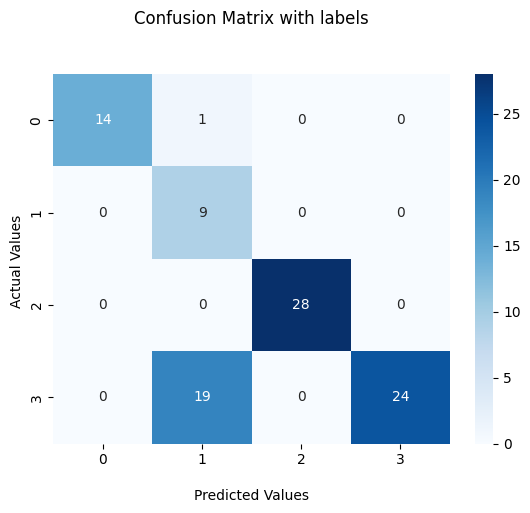

In [22]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.12      1.00      0.22         1
           2       1.00      1.00      1.00         8
           3       1.00      0.46      0.63        13

    accuracy                           0.73        26
   macro avg       0.78      0.87      0.71        26
weighted avg       0.97      0.73      0.79        26



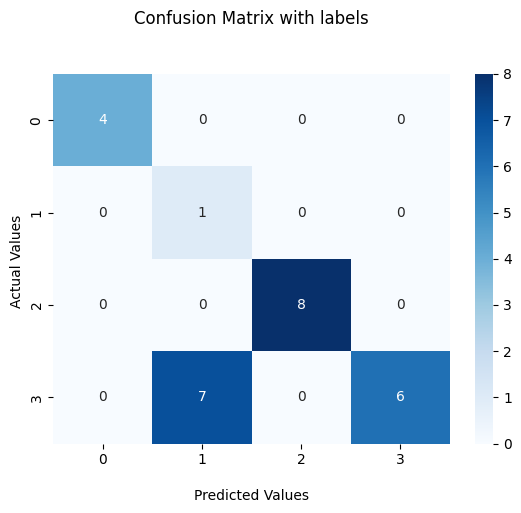

In [24]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
model.save('my_model.keras')

In [26]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Akzidenz Grotesk


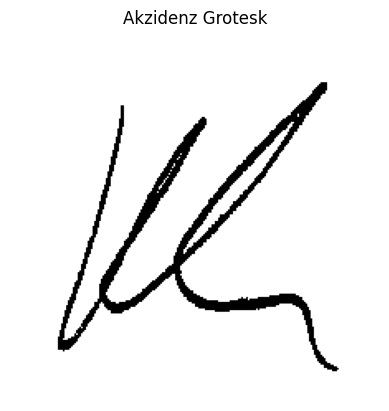

In [27]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Signature\Dataset\genuine\NFI-00305003.png"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Agency', 'Akzidenz Grotesk', 'Algerian', 'Arial']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()
